In [1]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.fitting.montecarlo import MCFitter
from pytpc.constants import *
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import yaml
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from scipy import interpolate

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = MCFitter(config)

In [3]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
clock = config['clock']
shape = config['shape']
pad_rot_angle = (config['pad_rot_angle']*math.pi)/180
electronics_gain = float(config['electronics_gain'])
micromegas_gain = float(config['micromegas_gain'])
diff_sigma = config['diffusion_sigma']
ioniz = 23.0 #eV

In [4]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 305
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
xyzs = np.array(xyzs_h5)

#delete the points which are farther away from the center of the spiral
del_list = []

DRIFT_VEL = 5.2
CLOCK = 12.5

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 40.0:
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0:
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): 
        del_list.append(i)         

cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(xyzs[0])

[-1.45741499e+02  9.06868891e-01  1.86516085e+02  5.14131784e+02
  9.18200000e+03  4.00000000e+00  1.47813910e+01]


In [5]:
######finding center of curvature#######
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

-43.91625428724363 9.816445862844423


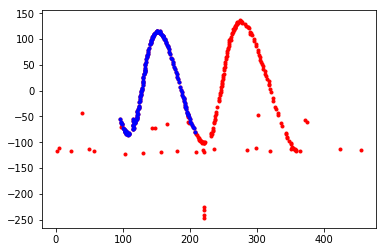

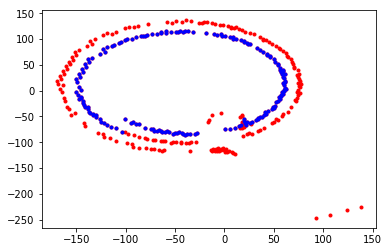

In [6]:
#######plotting real event#########
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

In [7]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
ctr0[4] += 2*pi
print(ctr0)

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False)
cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)
cut_exp_pos = cut_uvw_sorted[['u', 'v', 'w']].values.copy() / 1000
print(cut_ctr0)

[0.         0.         0.64505462 2.12373241 3.49679364 1.90405046]
[ 0.          0.          0.36338824  1.50750185 -2.7894479   1.90515488]


In [8]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [9]:
####### generate a set of parameter vectors within given range #########
sig = config['sigma']
sigma = np.array([sig['x'],sig['y'],sig['z'],sig['enu'],sig['azi']*math.pi/180,sig['pol']*math.pi/180])

num_events = 15000
candidates = [sigma]
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                               beam_origin_z, gas, num_events)

for evt in pgen:
    p = evt[0]
    try:
        if abs(p[0]-ctr0[0]) >= sigma[0]:
            raise ValueError
        elif abs(p[1]-ctr0[1]) >= sigma[1]:
            raise ValueError
        elif abs(p[2]-ctr0[2]) >= sigma[2]:
            raise ValueError
        elif abs(p[3]-ctr0[3]) >= sigma[3]:
            raise ValueError
        elif abs(p[4]-ctr0[4]) >= sigma[4]:
            raise ValueError
        elif abs(p[5]-ctr0[5]) >= sigma[5]:
            raise ValueError
    except ValueError:
        continue
    candidates = np.append(candidates, [p], axis=0)
candidates = np.delete(candidates0,0)


print(candidates)
print(len(candidates))

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:66: RuntimeWarning: invalid value encountered in sqrt
  pcm = np.sqrt(((s - m1**2 - m2**2)**2 - 4 * m1**2 * m2**2) / (4 * s))
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:67: RuntimeWarning: invalid value encountered in sqrt
  ppcm = np.sqrt(((s - m3**2 - m4**2)**2 - 4 * m3**2 * m4**2) / (4 * s))


[[ 1.00000000e-01  1.00000000e-01  1.00000000e-01  4.00000000e+00
   1.04719755e+00  5.23598776e-01]
 [-1.12777933e-02 -5.76655556e-03  6.09139362e-01  3.11412752e+00
   2.74615054e+00  2.14499585e+00]
 [ 7.93735362e-03 -1.06902514e-02  5.93616717e-01  1.21854883e+00
   3.40472166e+00  1.93997253e+00]
 ...
 [-4.49438419e-03 -7.49630479e-03  7.27930966e-01  4.72554551e+00
   3.00399007e+00  2.24313794e+00]
 [ 2.33476594e-03  6.83453161e-03  5.65098928e-01  6.83753637e-01
   2.80283951e+00  1.84469383e+00]
 [-3.41213581e-03 -4.51073406e-03  7.44556492e-01  3.97771705e+00
   3.38953572e+00  2.16792492e+00]]
619


In [31]:
####### find position deviations ########
sigmaPos = 5.0 ### in mm
Poschi2 = np.empty((0,0))
Poschi2_per_evt = np.empty((0,0))
sigmaEng = 0.1
sim = EventSimulator(config)
chi2En_per_evt = 0.0
hit_num = 0.0
EngChi2 = np.empty((0,0))
sigmaVert = 0.5e-4
Chi2Vert_per_evt = 0.0
VertChi2 = np.empty((0,0))

for num in range(1,501):
    
    chi2Pos_x = np.empty((0,0))
    chi2Pos_y = np.empty((0,0))
    
    evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                   candidates[num][3], candidates[num][4], candidates[num][5])
    pyevtClean = sim.convert_event(evtClean)
    sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                               baseline_correction=True, cg_times=True)
    
    ##### find energy chi2 #####
    hits = np.zeros(10240)
    for k, v in evtClean.items():
        hits[k] += v.max()
        
    sigmaEn = np.nanmax(exp_hits)*sigmaEng

    for p in range(10240):        
        if exp_hits[p] != 0:
            if np.isnan(exp_hits[p]) == False:
                chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2
                hit_num += 1.0

    EngChi2 = np.append(EngChi2,chi2En_per_evt/sigmaEn**2/hit_num)

    ##### find Vertex chi2 #####
    
    Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
    VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)
    print(VertChi2)
    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)
    
    ##### find position chi2 #####
    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])
    

    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x))
    sim_x[inds_x] = 0.0

    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y))
    sim_y[inds_y] = 0.0
        
#    if np.isnan(sum(sim_x[inds_x]-xyzs[:,0])) == True:
#        Poschi2 = np.append(Poschi2,100.0)
#    elif np.isnan(sum(sim_y-xyzs[:,1])) == True:
#        Poschi2 = np.append(Poschi2,100.0)

    chi2Pos_x = np.append(chi2Pos_x,(sim_x-xyzs[:,0])/float(sigmaPos))    
    chi2Pos_y = np.append(chi2Pos_y,(sim_y-xyzs[:,1])/float(sigmaPos)) 
    Poschi2 = np.append(Poschi2,sum(chi2Pos_y**2+chi2Pos_x**2)/float(len(xyzs)))
#    print(Poschi2)
#    for i in range(len(xyzs)):
#        if np.in1d(i, inds_x[0]) == False:
#            if np.in1d(i, inds_y[0]) == False:
#                chi2Pos_x = np.append(chi2Pos_x,(sim_x[i]-xyzs[i,0])/float(sigmaPos))
#                chi2Pos_y = np.append(chi2Pos_y,(sim_y[i]-xyzs[i,1])/float(sigmaPos)) 
#                Poschi2_per_evt = np.append(Poschi2_per_evt,chi2Pos_x**2+chi2Pos_y**2)
#            else:
#                continue
#        else:
#            continue

#    Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt)))
#    Poschi2_per_evt = np.empty((0,0))
    
    chi2En_per_evt = 0.0
    hit_num = 0.0
    
    Chi2Vert_per_evt = 0.0
    
min_chi = min(Poschi2+EngChi2+VertChi2)
print('minimum chi2:' + str(min_chi))
print(Poschi2[i]+EngChi2[i]+VertChi2[i])
for i in range(500):
    if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 10.0:
        print(i)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


[3.20883568]
[3.20883568 3.54566116]
[3.20883568 3.54566116 4.98066244]
[3.20883568 3.54566116 4.98066244 0.99942772]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852 6.98822582]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852 6.98822582 2.97332901]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852 6.98822582 2.97332901 5.59352963]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852 6.98822582 

[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852 6.98822582 2.97332901 5.59352963
 0.81098059 0.51847377 3.40361326 0.43673716 3.30251804 0.54502597
 3.8356523  0.26138479 4.57102584 5.57984147 2.12378436 1.87175795
 3.33898887 2.68142434 2.04036855 0.50662797 5.38526745 1.25159766
 4.21686207 1.3547263  2.10717365 2.79881642 2.91739541 4.04656776
 4.98606175 2.38616164 1.66704728 4.29601254]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.25324852 6.98822582 2.97332901 5.59352963
 0.81098059 0.51847377 3.40361326 0.43673716 3.30251804 0.54502597
 3.8356523  0.26138479 4.57102584 5.57984147 2.12378436 1.87175795
 3.33898887 2.68142434 2.04036855 0.50662797 5.38526745 1.25159766
 4.21686207 1.3547263  2.10717365 2.79881642 2.91739541 4.04656776
 4.98606175 2.38616164 1.66704728 4.29601254 0.15211419]
[3.20883568 3.54566116 4.98066244 0.99942772 4.58738303 0.11733205
 0.60798328 0.43822777 3.2

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00]
[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.2532

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

[3.20883568e+00 3.54566116e+00 4.98066244e+00 9.99427715e-01
 4.58738303e+00 1.17332052e-01 6.07983276e-01 4.38227765e-01
 3.25324852e+00 6.98822582e+00 2.97332901e+00 5.59352963e+00
 8.10980594e-01 5.18473772e-01 3.40361326e+00 4.36737158e-01
 3.30251804e+00 5.45025971e-01 3.83565230e+00 2.61384792e-01
 4.57102584e+00 5.57984147e+00 2.12378436e+00 1.87175795e+00
 3.33898887e+00 2.68142434e+00 2.04036855e+00 5.06627970e-01
 5.38526745e+00 1.25159766e+00 4.21686207e+00 1.35472630e+00
 2.10717365e+00 2.79881642e+00 2.91739541e+00 4.04656776e+00
 4.98606175e+00 2.38616164e+00 1.66704728e+00 4.29601254e+00
 1.52114193e-01 9.51018702e-01 2.84893820e+00 8.13889521e-01
 2.51089204e+00 4.40640915e+00 3.71994565e+00 7.75726678e-02
 6.61422482e+00 5.52345923e+00 1.82480779e+00 3.41634026e+00
 1.57114011e+00 5.95757206e+00 1.83230960e+00 5.18286189e-03
 1.07544342e+00 3.99617667e+00 6.70679487e-01 6.00318519e+00
 3.50427776e+00 6.91873585e+00 7.33972706e+00 6.16211517e+00
 5.32510960e+00 3.650539

In [28]:
########## position objective function revised ########
Poschi2 = np.empty((0,0))
Poschi2_per_evt = np.empty((0,0))
sim = EventSimulator(config)
chi2En_per_evt = 0.0
hit_num = 0.0
EngChi2 = np.empty((0,0))
sigmaVert = 0.5e-4
Chi2Vert_per_evt = 0.0
VertChi2 = np.empty((0,0))

for num in range(1,501):
    
    evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2], \
                                   candidates[num][3], candidates[num][4], candidates[num][5])
    pyevtClean = sim.convert_event(evtClean)
    sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, \
                               baseline_correction=True, cg_times=True)

    ##### find energy chi2 #####
    hits = np.zeros(10240)
    for k, v in evtClean.items():
        hits[k] += v.max()

    for p in range(10240):        
        if exp_hits[p] != 0:
            if np.isnan(exp_hits[p]) == False:
                chi2En_per_evt += (1.0-float(hits[int(p)])/float(exp_hits[int(p)]))**2
                hit_num += 1.0

    EngChi2 = np.append(EngChi2,chi2En_per_evt/hit_num)

    ##### find energy chi2 #####
    Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
    VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)
    
    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)
#    print(VertChi2)
    ##### find position chi2 #####
    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])

#    print(sim_x)
    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x)) #array with all the indicies that have a Nan
    sim_x[inds_x] = 0.0

    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y)) #array with all the indicies that have a Nan
    sim_y[inds_y] = 0.0
    
    Poschi2_per_evt = np.append(Poschi2_per_evt, sum((1.0-sim_x/xyzs[:,0])**2+(1.0-sim_y/xyzs[:,1])**2))

#    for i in range(len(xyzs)):
#        if np.in1d(i, inds_x[0]) == False: #include non-NaN only
#            if np.in1d(i, inds_y[0]) == False:
#                Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i]/xyzs[i,0])**2+(1.0-sim_y[i]/xyzs[i,1])**2)
#            else:
#                continue
#        else:
#            continue
    Poschi2 = np.append(Poschi2, Poschi2_per_evt/float(len(xyzs))/2.0)
    print(Poschi2)
    Poschi2_per_evt = np.empty((0,0))
    
    chi2En_per_evt = 0.0
    
    Chi2Vert_per_evt = 0.0

print(len(Poschi2))
print(len(EngChi2))
print(len(VertChi2))
min_chi = min(Poschi2+EngChi2+VertChi2)
print('minimum chi2:' + str(min_chi))
for i in range(500):
    if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 1e-5:
        print(i)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


[2.62003988]
[  2.62003988 351.82553897]
[  2.62003988 351.82553897 389.00066655]
[   2.62003988  351.82553897  389.00066655 1377.99863353]
[   2.62003988  351.82553897  389.00066655 1377.99863353   36.6047441 ]
[   2.62003988  351.82553897  389.00066655 1377.99863353   36.6047441
 2377.49950504]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01]
[2.620039

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03]
[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

[2.62003988e+00 3.51825539e+02 3.89000667e+02 1.37799863e+03
 3.66047441e+01 2.37749951e+03 2.16114276e+00 6.13218297e+01
 4.85707119e+01 3.03241105e+01 3.09138785e+01 7.68966285e+01
 1.03753067e+00 6.82694566e+02 8.22114802e+00 2.50506044e+03
 1.97869386e+02 2.82158474e+03 9.99143669e-01 1.06683843e+00
 3.22015952e+00 2.30440027e+03 1.53696166e+03 6.63094638e+01
 2.86432839e+00 3.84659836e+01 6.62507966e+01 3.69576945e+03
 3.34423538e+01 1.77786726e+03 1.26244051e+03 3.38798582e+03
 3.73211349e+00 2.75979295e+01 1.00143330e+01 7.07334804e+00
 6.86339694e+00 1.97928526e+03 5.68282122e+00 2.55860669e+00
 1.22705149e+03 1.03064163e+00 4.05887687e+01 1.46224289e+00
 1.97148329e+03 1.85484290e+03 4.14014939e+03 1.35674141e+02
 9.71849240e+01 1.62786219e+03 1.26540442e+01 5.04468095e+02
 4.73661911e+01 2.09512579e+03 1.02352554e+03 3.43184843e+01
 7.70007853e+01 2.98482760e+03 1.07470538e+03 1.59298381e+03
 4.19440280e+00 6.92430861e+01 1.42333056e+01 2.82319538e+01
 2.58519869e+03 1.296836

In [ ]:
##### find hit patterns and energy chi2 for simulated and real events #####
sigmaNormFraction = 0.1
hits = np.zeros(10240)
for k, v in evtClean.items():
    hits[k] += v.max()
    
sigmaEn = np.nanmax(exp_hits)*sigmaNormFraction

chi2En = 0
hit_num = 0
for a, p in uvw[['a', 'pad']].values:
    if exp_hits[int(p)] != 0:
        if np.isnan(exp_hits[int(p)]) == False:
            chi2En += (exp_hits[int(p)]-hits[int(p)])^2
            hit_num += 1

chi2En = chi2En/sigmaEn^2/hit_num

In [ ]:
###### find vert chi2 ######
sigmaVert = 0.5e-4

chi2Vert = (ctr0[0]^2 + ctr0[1]^2) / sigmaVert^2